In [1]:
# 환경 설정
!pip install git+https://github.com/autodistill/autodistill-grounded-sam-2 rf_groundingdino -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 62.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 23.8 MB/s eta 0:00:00


In [2]:
# 테스트 데이터 수집
!wget https://media.roboflow.com/containers.zip
!unzip containers.zip

--2024-11-21 09:58:08--  https://media.roboflow.com/containers.zip
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12356763 (12M) [application/zip]
Saving to: ‘containers.zip’

containers.zip      100%[===================>]  11.78M  7.34MB/s    in 1.6s    

2024-11-21 09:58:10 (7.34 MB/s) - ‘containers.zip’ saved [12356763/12356763]

Archive:  containers.zip
   creating: containers/
  inflating: containers/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-75_jpg.rf.ffbb8716eb886f91e3a561e2ba4be074.jpg  
  inflating: __MACOSX/containers/._Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-75_jpg.rf.ffbb8716eb886f91e3a561e2ba4be074.jpg  
  inflating: containers/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-169_jpg.rf.c0bf90f4b4bf5450508f6ccd5fd85e79.jpg  
  inflating: __MACOSX/containers/._Tips-and-tricks-on-how-to-park-a-ya

In [3]:
# SAM2 load
from autodistill_grounded_sam_2 import GroundedSAM2

Importing from timm.models.layers is deprecated, please import via timm.layers
Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.


In [4]:
from autodistill.detection import CaptionOntology
from autodistill.utils import plot
import numpy as np
import cv2
import os
import random
import supervision as sv

# define an ontology to map class names to our Grounded SAM 2 prompt
# the ontology dictionary has the format {caption: class}
# where caption is the prompt sent to the base model, and class is the label that will
# be saved for that caption in the generated annotations
# then, load the model
base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "shipping container": "container"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)


trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


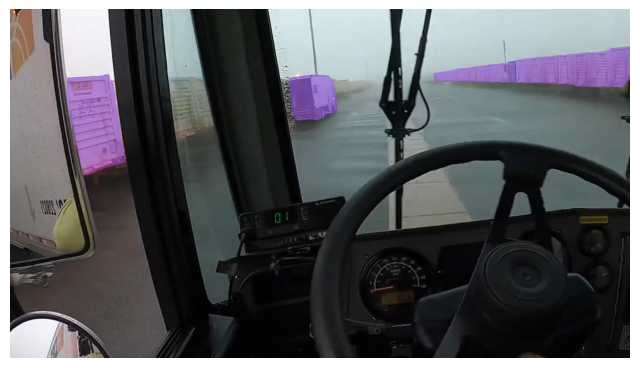

In [10]:
IMAGE_DIR = "/content/containers"
IMAGE_PATH = os.path.join(IMAGE_DIR, random.choice(os.listdir(IMAGE_DIR)))

results = base_model.predict(IMAGE_PATH).with_nms()
results = results[results.confidence > 0.3]

image = cv2.imread(IMAGE_PATH)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [11]:
base_model.label(IMAGE_DIR, extension="jpg")

Labeling /content/containers/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-41_jpg.rf.adecc0941eb2adfa26918641bd9ca2cb.jpg: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it]
Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


Found /content/containers_labeled/train/images/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-217_jpg.rf.c44bd9c9f22c3f0a9ff2688dfb0a1989.jpg as already present, not moving anything to /content/containers_labeled/train/images
Found /content/containers_labeled/train/labels/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-217_jpg.rf.c44bd9c9f22c3f0a9ff2688dfb0a1989.txt as already present, not moving anything to /content/containers_labeled/train/labels
Found /content/containers_labeled/train/images/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-36_jpg.rf.45252f84060180b5288ad551489e05a6.jpg as already present, not moving anything to /content/containers_labeled/train/images
Found /content/containers_labeled/train/labels/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-36_jpg.rf.45252f84060180b5288ad551489e05a6.txt as already present, not moving anything to /content/containers_labeled/train/labels
Found /content/containers_labeled/train/images/Tips-and-tricks-on-how-to-park-a-yard-j

In [9]:
import roboflow

roboflow.login()

rf = roboflow.Roboflow()

workspace = rf.workspace("segmentation")
workspace.upload_dataset(
    IMAGE_DIR + "_labeled/",
    "shipping-containers-kktus",
    project_license="MIT",
    project_type="Instance Segmentation",
)


visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...
Uploading to existing project segmentation/shipping-containers-kktus
[ERR] /content/containers_labeled/train/images/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-11_jpg.rf.7c82c1ce169049910ff85313d65292a1.jpg (Unsupported request. `POST /dataset/shipping-containers-kktus/upload` does not exist or cannot be loaded due to missing permissions.)
[ERR] /content/containers_labeled/train/images/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-13_jpg.rf.65c3ac314ae8c53f04a0b6eacdb02ace.jpg (Unsupported request. `POST /dataset/shipping-containers-kktus/upload` does not exist or cannot be loaded due to missing permissions.)
[ERR] /content/containers_labeled/train/images/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-10_jpg.rf.75a5875a4b8b4f8ce500dd53cf899d11.jpg (Unsupported request. `POST /dataset/shipping-con